<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_Net_with_VOC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision tqdm matplotlib

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # 컨볼루션 블록을 정의하는 함수
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # 3x3 컨볼루션, 패딩을 추가하여 출력 크기를 입력 크기와 같게 유지
                nn.BatchNorm2d(out_c),  # 배치 정규화
                nn.ReLU(inplace=True),  # ReLU 활성화 함수
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # 또 다른 3x3 컨볼루션
                nn.BatchNorm2d(out_c),  # 배치 정규화
                nn.ReLU(inplace=True)   # ReLU 활성화 함수
            )

        # 업샘플링(UpSampling)을 위한 함수 정의
        def up_conv(in_c, out_c):
            return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)  # 2x2 ConvTranspose로 업샘플링

        # 인코더(Encoder) 부분의 컨볼루션 블록 정의
        self.down1 = conv_block(in_channels, 64)  # 첫 번째 컨볼루션 블록, 입력 채널 -> 64 채널
        self.down2 = conv_block(64, 128)          # 두 번째 컨볼루션 블록, 64 채널 -> 128 채널
        self.down3 = conv_block(128, 256)         # 세 번째 컨볼루션 블록, 128 채널 -> 256 채널
        self.down4 = conv_block(256, 512)         # 네 번째 컨볼루션 블록, 256 채널 -> 512 채널
        self.down5 = conv_block(512, 1024)        # 다섯 번째 컨볼루션 블록, 512 채널 -> 1024 채널

        # 최대 풀링 레이어 정의 (인코더 단계 사이에 사용)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 최대 풀링

        # 디코더(Decoder) 부분의 업샘플링과 컨볼루션 블록 정의
        self.up4 = up_conv(1024, 512)             # 업샘플링: 1024 채널 -> 512 채널
        self.conv4 = conv_block(1024, 512)        # 컨볼루션 블록: 1024 채널 -> 512 채널 (skip connection과 concat)

        self.up3 = up_conv(512, 256)              # 업샘플링: 512 채널 -> 256 채널
        self.conv3 = conv_block(512, 256)         # 컨볼루션 블록: 512 채널 -> 256 채널 (skip connection과 concat)

        self.up2 = up_conv(256, 128)              # 업샘플링: 256 채널 -> 128 채널
        self.conv2 = conv_block(256, 128)         # 컨볼루션 블록: 256 채널 -> 128 채널 (skip connection과 concat)

        self.up1 = up_conv(128, 64)               # 업샘플링: 128 채널 -> 64 채널
        self.conv1 = conv_block(128, 64)          # 컨볼루션 블록: 128 채널 -> 64 채널 (skip connection과 concat)

        # 최종 출력 레이어 정의 (1x1 컨볼루션)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)  # 마지막 1x1 컨볼루션, 출력 채널 수 = 분류할 클래스 수

    # 순전파(Forward) 정의
    def forward(self, x):
        d1 = self.down1(x)                    # 첫 번째 컨볼루션 블록
        d2 = self.down2(self.pool(d1))        # 두 번째 컨볼루션 블록 + 풀링
        d3 = self.down3(self.pool(d2))        # 세 번째 컨볼루션 블록 + 풀링
        d4 = self.down4(self.pool(d3))        # 네 번째 컨볼루션 블록 + 풀링
        d5 = self.down5(self.pool(d4))        # 다섯 번째 컨볼루션 블록 + 풀링

        up4 = self.up4(d5)                    # 첫 번째 업샘플링
        merge4 = torch.cat([up4, d4], dim=1)  # 업샘플링된 결과와 대응하는 인코딩 결과를 합침 (skip connection)
        c4 = self.conv4(merge4)               # 컨볼루션 블록

        up3 = self.up3(c4)                    # 두 번째 업샘플링
        merge3 = torch.cat([up3, d3], dim=1)  # 업샘플링된 결과와 대응하는 인코딩 결과를 합침 (skip connection)
        c3 = self.conv3(merge3)               # 컨볼루션 블록

        up2 = self.up2(c3)                    # 세 번째 업샘플링
        merge2 = torch.cat([up2, d2], dim=1)  # 업샘플링된 결과와 대응하는 인코딩 결과를 합침 (skip connection)
        c2 = self.conv2(merge2)               # 컨볼루션 블록

        up1 = self.up1(c2)                    # 네 번째 업샘플링
        merge1 = torch.cat([up1, d1], dim=1)  # 업샘플링된 결과와 대응하는 인코딩 결과를 합침 (skip connection)
        c1 = self.conv1(merge1)               # 컨볼루션 블록

        return self.final(c1)                 # 최종 출력 레이어

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

# 하이퍼파라미터 설정
batch_size = 8
image_size = (256, 256)  # 고정된 이미지 크기 설정

# 이미지 전처리 정의 (크기 조정, 텐서 변환, 정규화)
transform = transforms.Compose([
    transforms.Resize(image_size),  # 이미지 크기 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

# 마스크 전처리 정의
target_transform = transforms.Compose([
    transforms.Resize(image_size),  # 마스크 크기 조정
    transforms.ToTensor()           # 마스크를 텐서로 변환
])

# PASCAL VOC 2012 훈련 데이터셋 로드
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True,
                                transform=transform, target_transform=target_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# PASCAL VOC 2012 테스트 데이터셋 로드
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True,
                               transform=transform, target_transform=target_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 모델, 손실 함수, 옵티마이저, 스케줄러 설정
model = UNet(in_channels=3, out_channels=21).cuda()  # U-Net 모델 인스턴스 생성, 3채널 입력, 21채널 출력 (VOC 2012 클래스 수)
criterion = nn.CrossEntropyLoss()                    # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam 옵티마이저 사용
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)  # 학습률 감소 스케줄러 설정

num_epochs = 20  # 학습 에폭 수

# 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images = images.cuda()                  # 이미지를 GPU로 전송
        masks = masks.squeeze(1).long().cuda()  # 마스크도 GPU로 전송 및 차원 조정

        # 순전파
        outputs = model(images)  # 모델에 이미지를 입력하여 출력(예측) 생성
        loss = criterion(outputs, masks)  # 손실 계산

        # 역전파 및 최적화
        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        loss.backward()        # 손실에 대한 기울기 계산
        optimizer.step()       # 옵티마이저가 기울기를 사용하여 가중치 업데이트

        running_loss += loss.item()

        if (i+1) % 10 == 0:  # 매 10번째 배치마다 손실 출력
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # 스케줄러를 사용하여 에폭 손실에 따라 학습률 조정
    scheduler.step(running_loss / len(train_loader))

    # 테스트셋 평가
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
        total = 0
        correct = 0
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.squeeze(1).long().cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 각 픽셀에 대해 예측한 클래스 선택
            total += masks.nelement()  # 전체 픽셀 수 계산
            correct += (predicted == masks).sum().item()  # 정확히 예측된 픽셀 수 계산

        accuracy = 100 * correct / total  # 정확도 계산
        print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# 모델 저장
torch.save(model.state_dict(), 'unet_voc2012.pth')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Step [10/183], Loss: 2.8297
Epoch [1/20], Step [20/183], Loss: 2.5940
Epoch [1/20], Step [30/183], Loss: 2.3378
Epoch [1/20], Step [40/183], Loss: 2.1945
Epoch [1/20], Step [50/183], Loss: 2.0820
Epoch [1/20], Step [60/183], Loss: 2.0254
Epoch [1/20], Step [70/183], Loss: 1.9650
Epoch [1/20], Step [80/183], Loss: 1.9819
Epoch [1/20], Step [90/183], Loss: 1.9000
Epoch [1/20], Step [100/183], Loss: 1.8466
Epoch [1/20], Step [110/183], Loss: 1.7835
Epoch [1/20], Step [120/183], Loss: 1.7347
Epoch [1/20], Step [130/183], Loss: 1.7563
Epoch [1/20], Step [140/183], Loss: 1.7755
Epoch [1/20], Step [150/183], Loss: 1.6598
Epoch [1/20], Step [160/183], Loss: 1.6711
Epoch [1/20], Step [170/183], Loss: 1.6001
Epoch [1/20], Step [180/183], Loss: 1.5375
Accuracy of the model on the test images: 93.85%
Epoch [2/20], Step [10/183], Loss: 1.5135
Epoch [2/20], Step [20/183], Loss: 1.4808
Epoch [2/20], Step [30/183], Loss: 1.4018
Epoch [2/20], Step [40/183], Loss: 1.4705
Epoch [2/20], Step

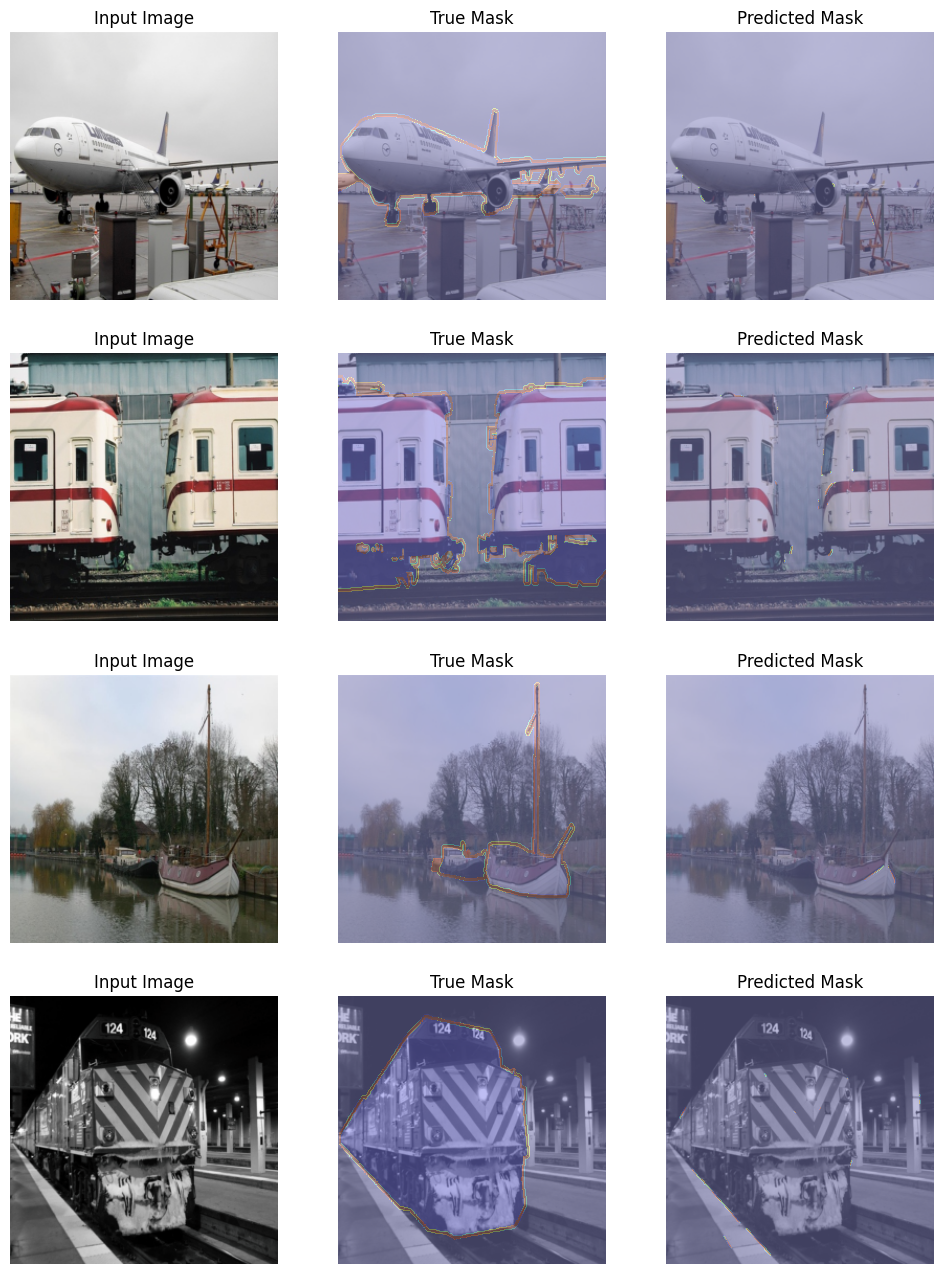

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# 정규화된 이미지를 원래 상태로 복원하는 함수
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # std로 곱하고 mean을 더함
    return tensor

# 예측 결과를 시각화하는 함수
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()  # 모델을 평가 모드로 설정
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():  # 시각화 시 기울기 계산은 필요 없음
        images, masks = next(iter(dataloader))  # 테스트 데이터의 첫 배치를 가져옴
        images = images.cuda()
        outputs = model(images)  # 모델 예측
        _, predicted = torch.max(outputs.data, 1)  # 예측 결과에서 가장 높은 확률의 클래스를 선택

        # 시각화를 위한 figure와 axes 생성
        fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
        for i in range(num_images):
            # 원래 이미지 복원
            img = images[i].cpu().clone()
            img = unnormalize(img, mean, std)
            img = F.to_pil_image(img)

            true_mask = masks[i].squeeze().cpu().numpy()  # 실제 마스크
            pred_mask = predicted[i].cpu().numpy()  # 예측 마스크

            axes[i, 0].imshow(img)  # 원래 이미지 시각화
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(true_mask, cmap='jet', alpha=0.5)  # 실제 마스크 시각화
            axes[i, 1].imshow(img, alpha=0.5)
            axes[i, 1].set_title("True Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask, cmap='jet', alpha=0.5)  # 예측 마스크 시각화
            axes[i, 2].imshow(img, alpha=0.5)
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

        plt.show()

# 테스트 데이터셋에서 예측 시각화
visualize_predictions(model, test_loader, num_images=4)